In [1]:
import numpy as np
from sklearn.neighbors import KernelDensity
from sklearn.preprocessing import MinMaxScaler
import os
from sklearn.preprocessing import StandardScaler
import seaborn as sns
import matplotlib.pyplot as plt

import pandas as pd
import sys

In [2]:
os.chdir("../")
folder_path = os.path.abspath("functions/") #INPUT_PATH)#'path_to_your_folder')  # Replace with the actual folder path
sys.path.insert(0, folder_path)

from Predictions import (
    SERA,
    PredictionModel,
    compute_adjusted_boxplot_bounds,
    piecewise_linear_phi,
    create_relevance_function
)

c:\Users\marti\AppData\Local\Programs\Python\Python310\lib\site-packages\tensorflow_addons\utils\tfa_eol_msg.py:23: UserWarning: 

TensorFlow Addons (TFA) has ended development and introduction of new features.
TFA has entered a minimal maintenance and release mode until a planned end of life in May 2024.
Please modify downstream libraries to take dependencies from other repositories in our TensorFlow community (e.g. Keras, Keras-CV, and Keras-NLP). 

For more information see: https://github.com/tensorflow/addons/issues/2807 

  warnings.warn(


In [3]:
def kde(y,  bandwidth="scott", kernel='gaussian'):
    y = y.reshape(-1, 1)
    # Fit KDE
    kde = KernelDensity(kernel=kernel, bandwidth=bandwidth)
    kde.fit(y)

    def kde_fitted(y_val):
        y_val = np.array(y_val).reshape(-1, 1)
        log_dens = kde.score_samples(y_val)
        dens = np.exp(log_dens)
        return dens
    return kde_fitted

def kde_based_relevance_function(y, bandwidth=0.1, kernel='gaussian'):
    y = y.reshape(-1, 1)

    # Fit KDE
    kde = KernelDensity(kernel=kernel, bandwidth=bandwidth)
    kde.fit(y)

    # Evaluate KDE and compute inverse density
    log_density = kde.score_samples(y)
    density = np.exp(log_density)
    inv_density = 1.0 / density

    # Normalize manually
    min_val = np.min(inv_density)
    max_val = np.max(inv_density)
    range_val = max_val - min_val if max_val != min_val else 1.0

    def phi_fn(y_val):
        y_val = np.array(y_val).reshape(-1, 1)
        log_dens = kde.score_samples(y_val)
        dens = np.exp(log_dens)
        inv_dens = 1.0 / dens
        phi = (inv_dens - min_val) / range_val
        return np.clip(phi, 0.0, 1.0)

    return phi_fn

Text(0.5, 0.98, 'Histogram of each index')

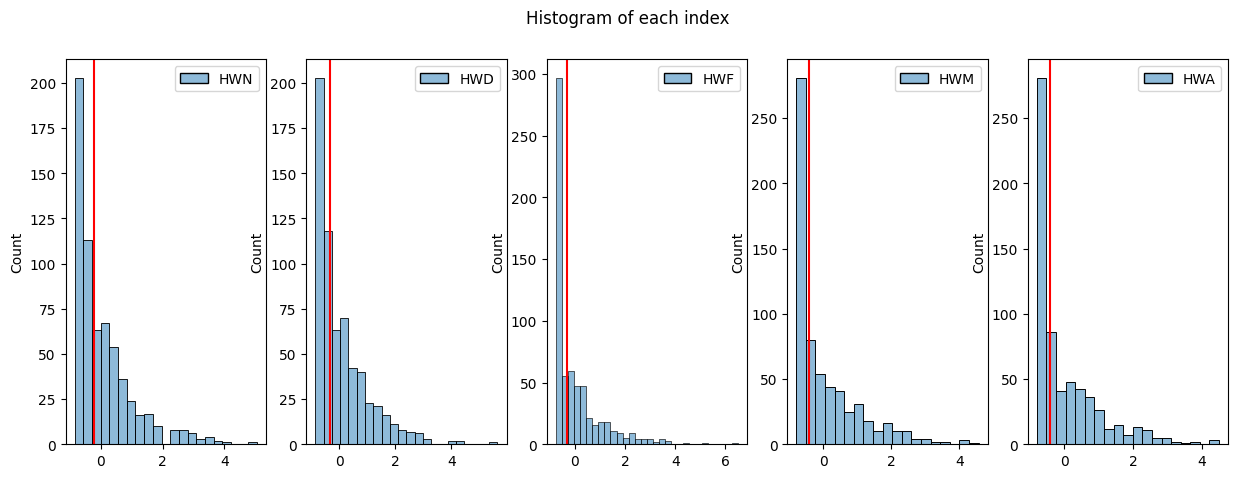

In [11]:
def read_hws(path, date_format='%Y-%m'):
    data = pd.read_csv(path)
    data["Date"] = pd.to_datetime(data["Date"],format=date_format)
    data.set_index('Date', inplace=True)
    return data

region = "chile"
indices = ["HWN", "HWD", "HWF", "HWM", "HWA"]

hws = read_hws(f"data/local_data/monthly/HWs_chile_central.csv")
scaler = StandardScaler()
hws[indices] = scaler.fit_transform(hws[indices])
indices = ["HWN", "HWD", "HWF", "HWM", "HWA"]
fig, axs = plt.subplots(1, 5, figsize=(15,5))
for i, index in enumerate(indices):
    sns.histplot(hws[[index]], ax=axs[i])
    axs[i].axvline(np.median(hws[[index]]), color='red')

fig.suptitle("Histogram of each index")

Text(0.5, 0.98, 'KDE aproximation of each index')

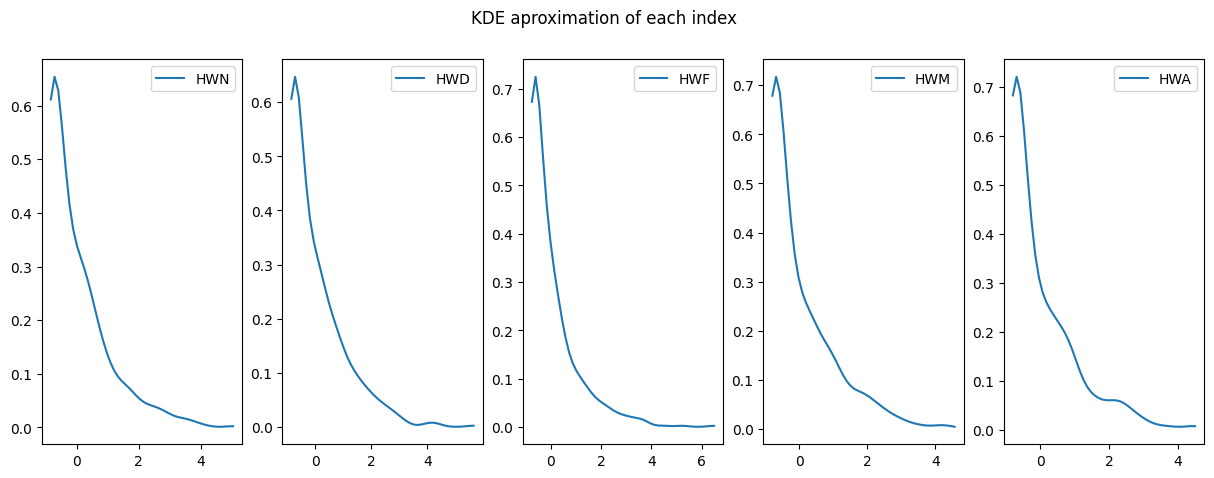

In [12]:
fig, axs = plt.subplots(1, 5, figsize=(15,5))
for i, index in enumerate(indices):
    hws_index = hws[[index]].to_numpy()
    hws_index = hws_index.reshape(hws_index.shape[0])
    x = np.linspace(np.min(hws_index), np.max(hws_index))
    kde_fitted = kde(hws_index, bandwidth="scott")
    axs[i].plot(x, kde_fitted(x), label=index)
    axs[i].legend()
fig.suptitle("KDE aproximation of each index")

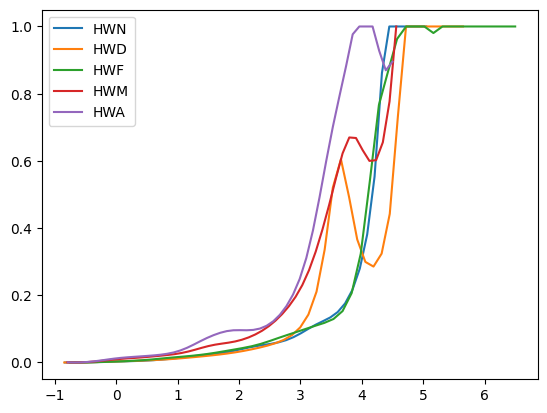

Text(0.5, 0.98, 'Inverse density approx')

In [29]:
relevance_index = {}
for index in indices:
    hws_index = hws[[index]].to_numpy()
    hws_index = hws_index.reshape(hws_index.shape[0])
    x = np.linspace(np.min(hws_index), np.max(hws_index))
    relevance = kde_based_relevance_function(hws_index, bandwidth="scott")
    relevance_index[index] = relevance
    plt.plot(x, relevance(x), label=index)
plt.legend()
plt.show()
fig.suptitle("Inverse density approx")

Text(0.5, 0.98, 'KDE relevance vs Boxplot relevance')

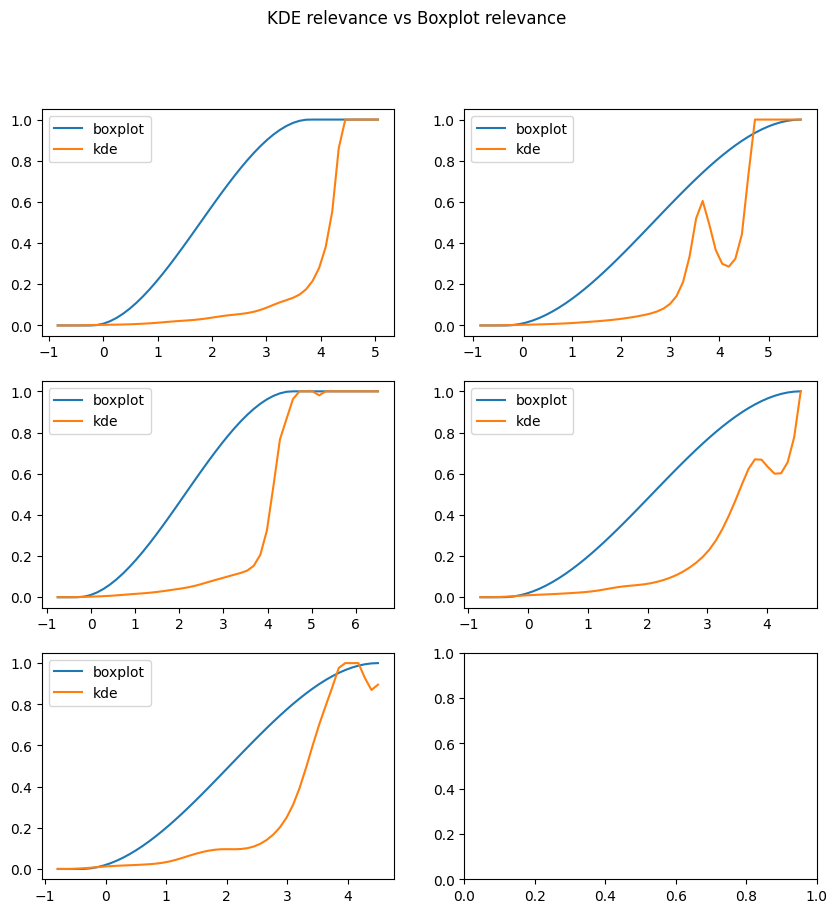

In [14]:
fig, axs = plt.subplots(3, 2, figsize=(10,10))
axs = axs.flatten()
for i, index in enumerate(indices):
    hws_index = hws[[index]].to_numpy()
    hws_index = hws_index.reshape(hws_index.shape[0])
    relevance = create_relevance_function(hws_index)
    x = np.linspace(np.min(hws_index), np.max(hws_index))
    kde_relevance = kde_based_relevance_function(hws_index, bandwidth="scott")
    axs[i].plot(x, relevance(x), label="boxplot")
    axs[i].plot(x, kde_relevance(x), label="kde")
    axs[i].legend()
fig.suptitle("KDE relevance vs Boxplot relevance")


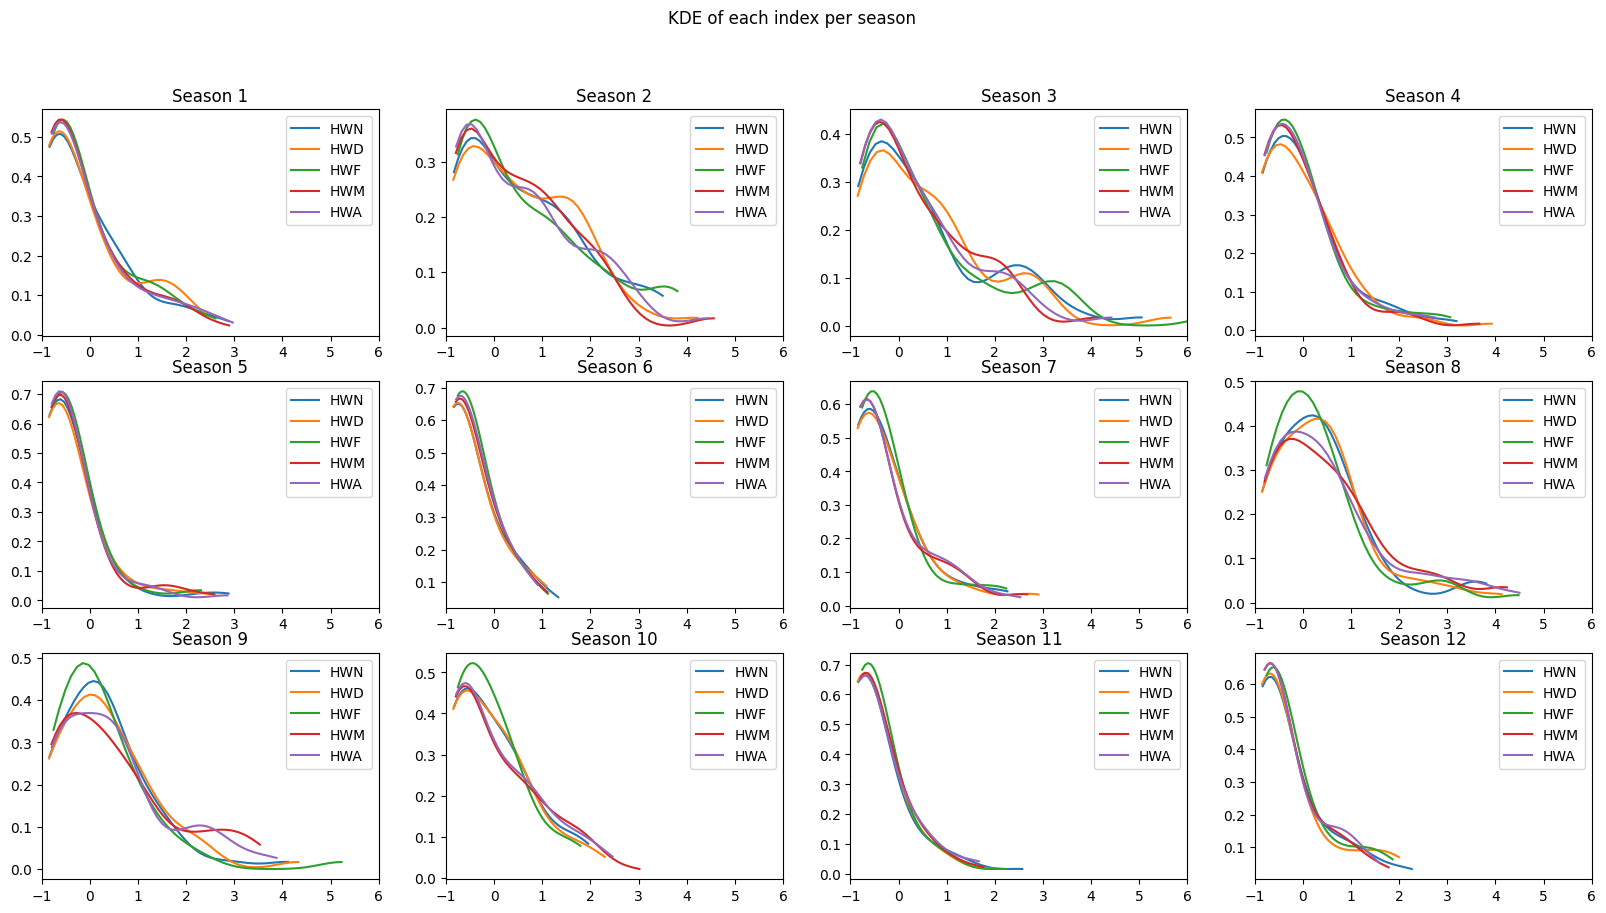

In [16]:
fig, axs = plt.subplots(3, 4, figsize=(20,10))
axs = axs.flatten()
for i in range(12):
    hws_month = hws[hws.index.month==i+1]
    for index in indices:
        hws_index = hws_month[[index]].to_numpy()
        hws_index = hws_index.reshape(hws_index.shape[0])
        x = np.linspace(np.min(hws_index), np.max(hws_index))
        kde_fitted = kde(hws_index, bandwidth="scott")
        axs[i].plot(x, kde_fitted(x), label=index)
        axs[i].set_xlim(-1, 6)
    axs[i].legend()
    axs[i].set_title(f"Season {i+1}")
fig.suptitle("KDE of each index per season")
plt.show()



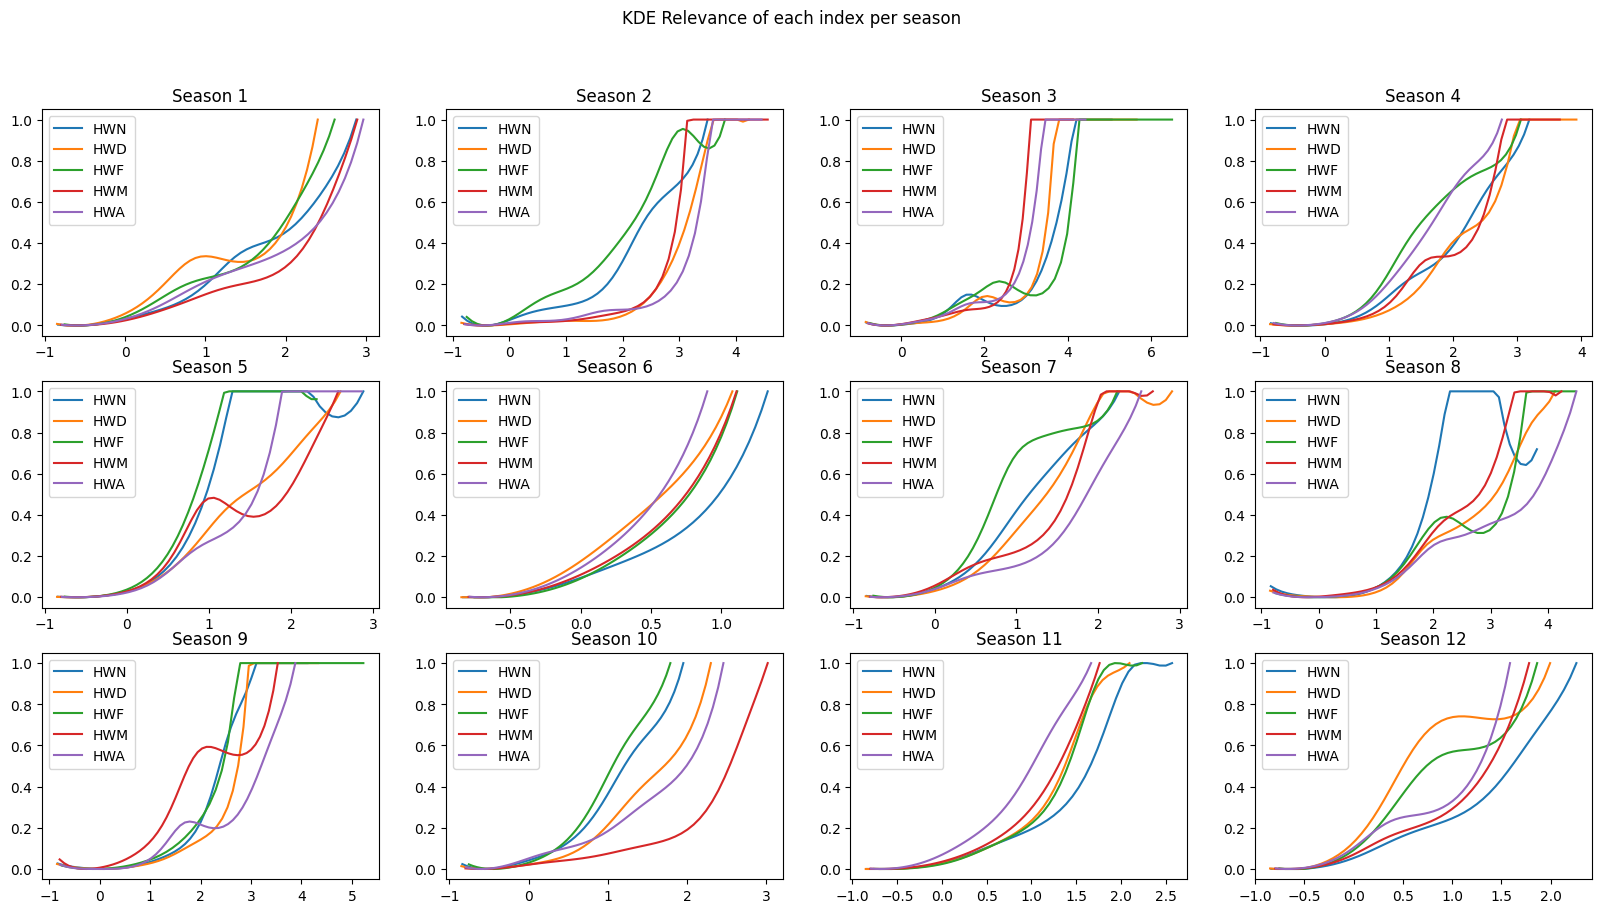

In [17]:
fig, axs = plt.subplots(3, 4, figsize=(20,10))
axs = axs.flatten()
for i in range(12):
    hws_month = hws[hws.index.month==i+1]
    for index in indices:
        hws_index = hws_month[[index]].to_numpy()
        hws_index = hws_index.reshape(hws_index.shape[0])
        x = np.linspace(np.min(hws_index), np.max(hws_index))
        kde_relevance = kde_based_relevance_function(hws_index, bandwidth="scott")
        axs[i].plot(x, kde_relevance(x), label=index)
    axs[i].legend()
    axs[i].set_title(f"Season {i+1}")
fig.suptitle("KDE Relevance of each index per season")
plt.show()


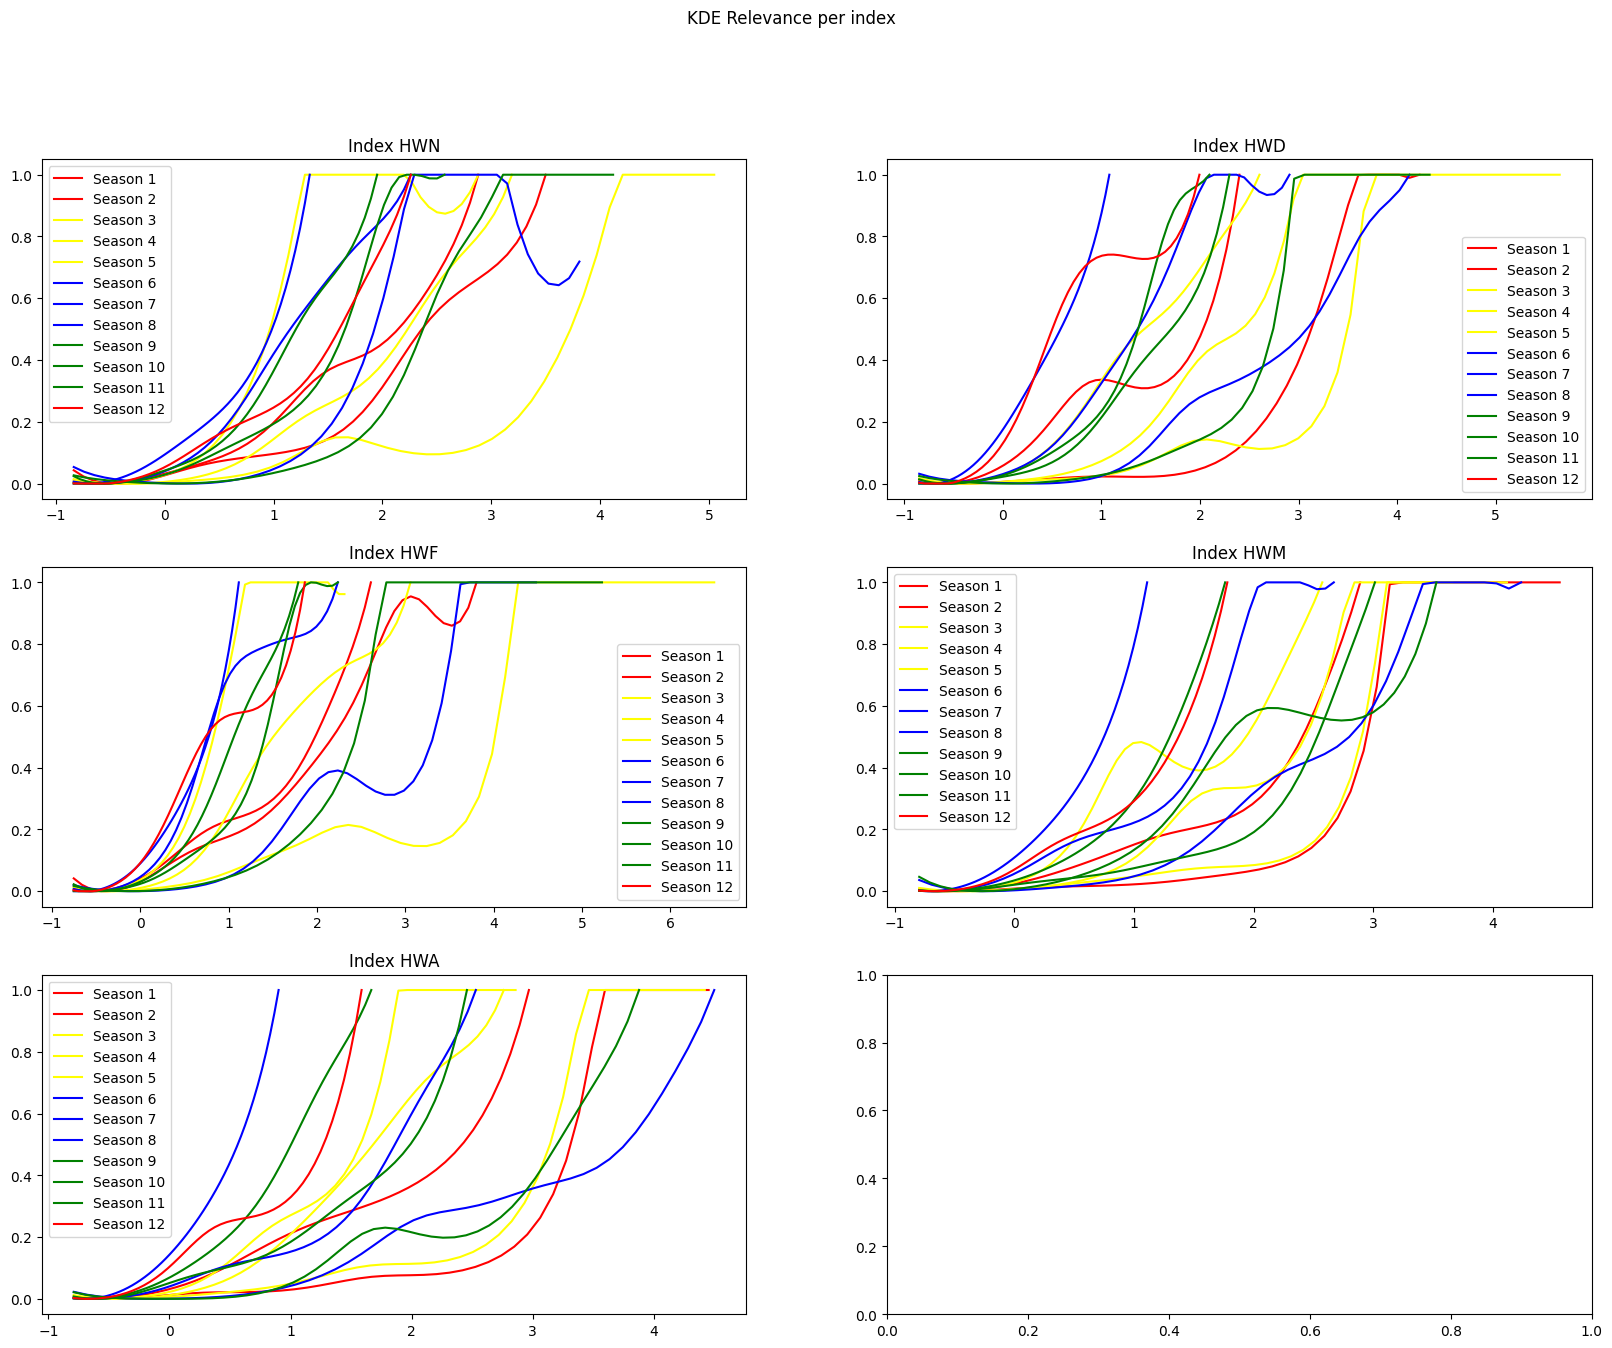

In [18]:
fig, axs = plt.subplots(3, 2, figsize=(20,15))
axs = axs.flatten()
colors = {
    1: "red",
    2: "red",
    3: "yellow",
    4: "yellow",
    5: "yellow",
    6: "blue",
    7: "blue",
    8: "blue",
    9: "green",
    10: "green",
    11: "green",
    12: "red"
}
for k, index in enumerate(indices):
    for i in range(12):
        hws_month = hws[hws.index.month==i+1]
        hws_index = hws_month[[index]].to_numpy()
        hws_index = hws_index.reshape(hws_index.shape[0])
        x = np.linspace(np.min(hws_index), np.max(hws_index))
        kde_relevance = kde_based_relevance_function(hws_index, bandwidth="scott")
        axs[k].plot(x, kde_relevance(x), label=f"Season {i+1}", c=colors[i+1])
    axs[k].legend()
    axs[k].set_title(f"Index {index}")
fig.suptitle("KDE Relevance per index")
plt.show()


C:\Users\marti\AppData\Local\Temp\ipykernel_12128\2642970809.py:35: RuntimeWarning: divide by zero encountered in divide
  inv_dens = 1.0 / dens
C:\Users\marti\AppData\Local\Temp\ipykernel_12128\2642970809.py:35: RuntimeWarning: divide by zero encountered in divide
  inv_dens = 1.0 / dens
C:\Users\marti\AppData\Local\Temp\ipykernel_12128\2642970809.py:35: RuntimeWarning: divide by zero encountered in divide
  inv_dens = 1.0 / dens
C:\Users\marti\AppData\Local\Temp\ipykernel_12128\2642970809.py:35: RuntimeWarning: divide by zero encountered in divide
  inv_dens = 1.0 / dens
C:\Users\marti\AppData\Local\Temp\ipykernel_12128\2642970809.py:35: RuntimeWarning: overflow encountered in divide
  inv_dens = 1.0 / dens
C:\Users\marti\AppData\Local\Temp\ipykernel_12128\2642970809.py:35: RuntimeWarning: divide by zero encountered in divide
  inv_dens = 1.0 / dens
C:\Users\marti\AppData\Local\Temp\ipykernel_12128\2642970809.py:35: RuntimeWarning: divide by zero encountered in divide
  inv_dens = 1.

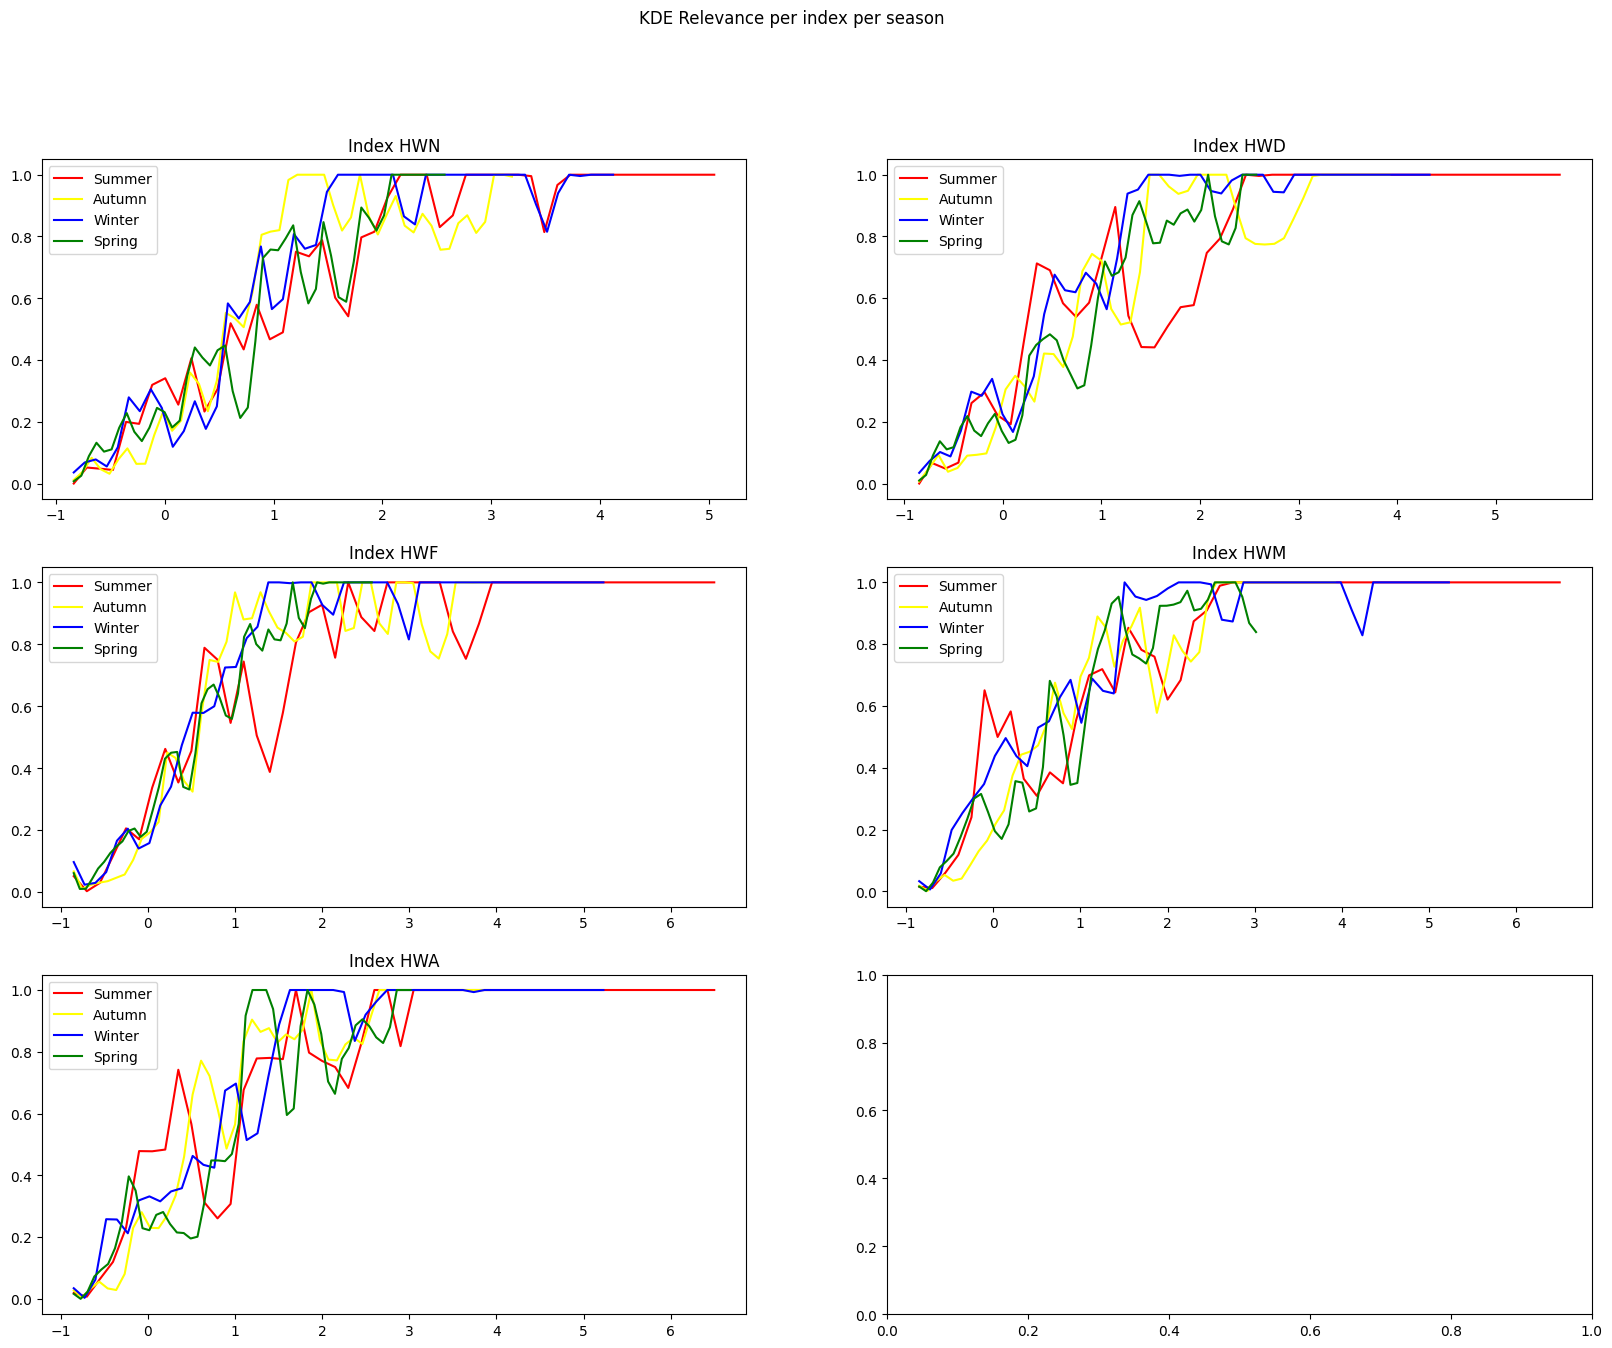

In [19]:
x = np.linspace(-1, 7)
fig, axs = plt.subplots(3, 2, figsize=(20,15))
axs = axs.flatten()
season_min_max = {
    "summer": [1, 1],
    "autumn": [1, 1],
    "winter": [1, 1],
    "spring": [1, 1]
}
xs_seasons = {}
for k, index in enumerate(indices):
    relevance_index = {}
    for i in range(12):
        hws_month = hws[hws.index.month==i+1]
        hws_index = hws_month[[index]].to_numpy()
        hws_index = hws_index.reshape(hws_index.shape[0])
        relevance = kde_based_relevance_function(hws_index)
        relevance_index[i+1] = relevance
        if i in [12, 1, 2]:
            if season_min_max["summer"][0] > np.min(hws_index):
                season_min_max["summer"][0] = np.min(hws_index)
            if season_min_max["summer"][1] < np.max(hws_index):
                season_min_max["summer"][1] = np.max(hws_index)
            xs_seasons["summer"] = np.linspace(season_min_max["summer"][0], season_min_max["summer"][1])
        if i in [3, 4, 5]:
            if season_min_max["autumn"][0] > np.min(hws_index):
                season_min_max["autumn"][0] = np.min(hws_index)
            if season_min_max["autumn"][1] < np.max(hws_index):
                season_min_max["autumn"][1] = np.max(hws_index)
            xs_seasons["autumn"] = np.linspace(season_min_max["autumn"][0], season_min_max["autumn"][1])
        if i in [6, 7, 8]:
            if season_min_max["winter"][0] > np.min(hws_index):
                season_min_max["winter"][0] = np.min(hws_index)
            if season_min_max["winter"][1] < np.max(hws_index):
                season_min_max["winter"][1] = np.max(hws_index)
            xs_seasons["winter"] = np.linspace(season_min_max["winter"][0], season_min_max["winter"][1])
        if i in [9, 10, 11]:
            if season_min_max["spring"][0] > np.min(hws_index):
                season_min_max["spring"][0] = np.min(hws_index)
            if season_min_max["spring"][1] < np.max(hws_index):
                season_min_max["spring"][1] = np.max(hws_index)
            xs_seasons["spring"] = np.linspace(season_min_max["spring"][0], season_min_max["spring"][1])
    x = xs_seasons["summer"]
    axs[k].plot(x, (relevance_index[1](x) + relevance_index[2](x) + relevance_index[12](x))/3, label=f"Summer", c="red")
    x = xs_seasons["autumn"]
    axs[k].plot(x, (relevance_index[3](x) + relevance_index[4](x) + relevance_index[5](x))/3, label=f"Autumn", c="yellow")
    x = xs_seasons["winter"]
    axs[k].plot(x, (relevance_index[6](x) + relevance_index[7](x) + relevance_index[8](x))/3, label=f"Winter", c="blue")
    x = xs_seasons["spring"]
    axs[k].plot(x, (relevance_index[9](x) + relevance_index[10](x) + relevance_index[11](x))/3, label=f"Spring", c="green")
    axs[k].legend()
    axs[k].set_title(f"Index {index}")
fig.suptitle("KDE Relevance per index per season")
plt.show()


## Model Optimization

In [17]:

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import SimpleRNN, LSTM, Dense, Dropout, GRU, Conv1D, Flatten, Reshape

import tensorflow as tf

In [38]:
def piecewise_linear_phi(y, bounds, y_bounds):
    x1, x2, x3, x4, x5, x6, x7 = tf.unstack(bounds)
    # iqr = (x3-x2)
    # x1, x2, x3, x4,  = x1, x2, x2+iqr/4, x2+ iqr/2, x2 + iqr*0.75, x3, x4
    # y1, y2, y3, y4, y5, y6, y7 = 0, 0.2, 0.4, 0.5, 0.82, 1, 1
    y1, y2, y3, y4, y5, y6, y7 = tf.unstack(y_bounds)

    return tf.where(
        y <= x1, tf.zeros_like(y),
        tf.where(
            y <= x2,  y2 + (y2-y1)/(x2-x1)*(y-x2),
            tf.where(
                y <= x3, y3 + (y3-y2)/(x3-x2)*(y-x3),
                tf.where(
                    y <= x4, y4 + (y4-y3)/(x4-x3)*(y-x4),
                    tf.where(
                        y <= x5, y5 + (y5-y4)/(x5-x4)*(y-x5),
                        tf.where(
                            y <= x6, y6 + (y6-y5)/(x6-x5)*(y-x6), 
                            tf.where(
                                y <= x7, tf.ones_like(y), tf.ones_like(y) 
                            )
                        )
                    )
                )
            )
        )
    )

class SERA(tf.keras.losses.Loss):
    def __init__(self, bounds, y_bounds, T=100, name="sera_loss"):
        super().__init__(name=name)
        self.bounds = tf.constant(bounds, dtype=tf.float32)
        self.y_bounds = tf.constant(y_bounds, dtype=tf.float32)
        self.T = T
        self.thresholds = tf.linspace(0.0, 1.0, T + 1)
        # self.relevance = relevance_fn

    def call(self, y_true, y_pred):
        y_true = tf.reshape(y_true, [-1])
        y_pred = tf.reshape(y_pred, [-1])
        errors = tf.square(y_pred - y_true)
        relevance = piecewise_linear_phi(y_true, self.bounds, self.y_bounds)

        total = tf.constant(0.0, dtype=tf.float32)
        for i in range(self.T + 1):
            t = self.thresholds[i]
            mask = relevance >= t
            masked_errors = tf.boolean_mask(errors, mask)
            if tf.size(masked_errors) > 0:
                weight = 0.5 if (i == 0 or i == self.T) else 1.0
                total += weight * tf.reduce_sum(masked_errors)

        return total / tf.cast(self.T, tf.float32)

In [39]:
hws_index = hws[["HWF"]].to_numpy()
hws_index = hws_index.reshape(hws_index.shape[0])
relevance = kde_based_relevance_function(hws_index)

In [40]:
x = np.linspace(np.min(hws_index), np.max(hws_index))
print(x.shape)

(50,)


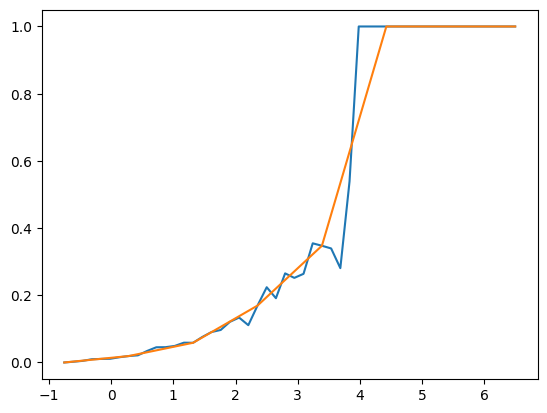

In [41]:
x = np.linspace(np.min(hws_index), np.max(hws_index))
bounds = (x[0], x[7], x[14], x[21], x[28], x[35], x[42])
y_bounds = [relevance(xs) for xs in bounds]
# f2 = piecewise_linear_phi(hws_index, bounds)
plt.plot(x, relevance(x))
plt.plot(x, piecewise_linear_phi(x, bounds, y_bounds))

Epoch 1/200
6/6 [==============================] - 17s 725ms/step - loss: 13.1973 - mae: 0.6788 - val_loss: 10.1807 - val_mae: 0.8968
Epoch 2/200
6/6 [==============================] - 0s 7ms/step - loss: 12.8146 - mae: 0.6844 - val_loss: 9.7651 - val_mae: 0.8832
Epoch 3/200
6/6 [==============================] - 0s 8ms/step - loss: 12.3256 - mae: 0.6580 - val_loss: 9.4347 - val_mae: 0.8729
Epoch 4/200
6/6 [==============================] - 0s 8ms/step - loss: 12.0262 - mae: 0.6735 - val_loss: 9.1495 - val_mae: 0.8637
Epoch 5/200
6/6 [==============================] - 0s 8ms/step - loss: 12.6069 - mae: 0.6521 - val_loss: 8.9102 - val_mae: 0.8552
Epoch 6/200
6/6 [==============================] - 0s 8ms/step - loss: 11.9191 - mae: 0.6617 - val_loss: 8.6889 - val_mae: 0.8488
Epoch 7/200
6/6 [==============================] - 0s 8ms/step - loss: 11.7138 - mae: 0.6714 - val_loss: 8.5361 - val_mae: 0.8451
Epoch 8/200
6/6 [==============================] - 0s 8ms/step - loss: 11.4999 - mae: 

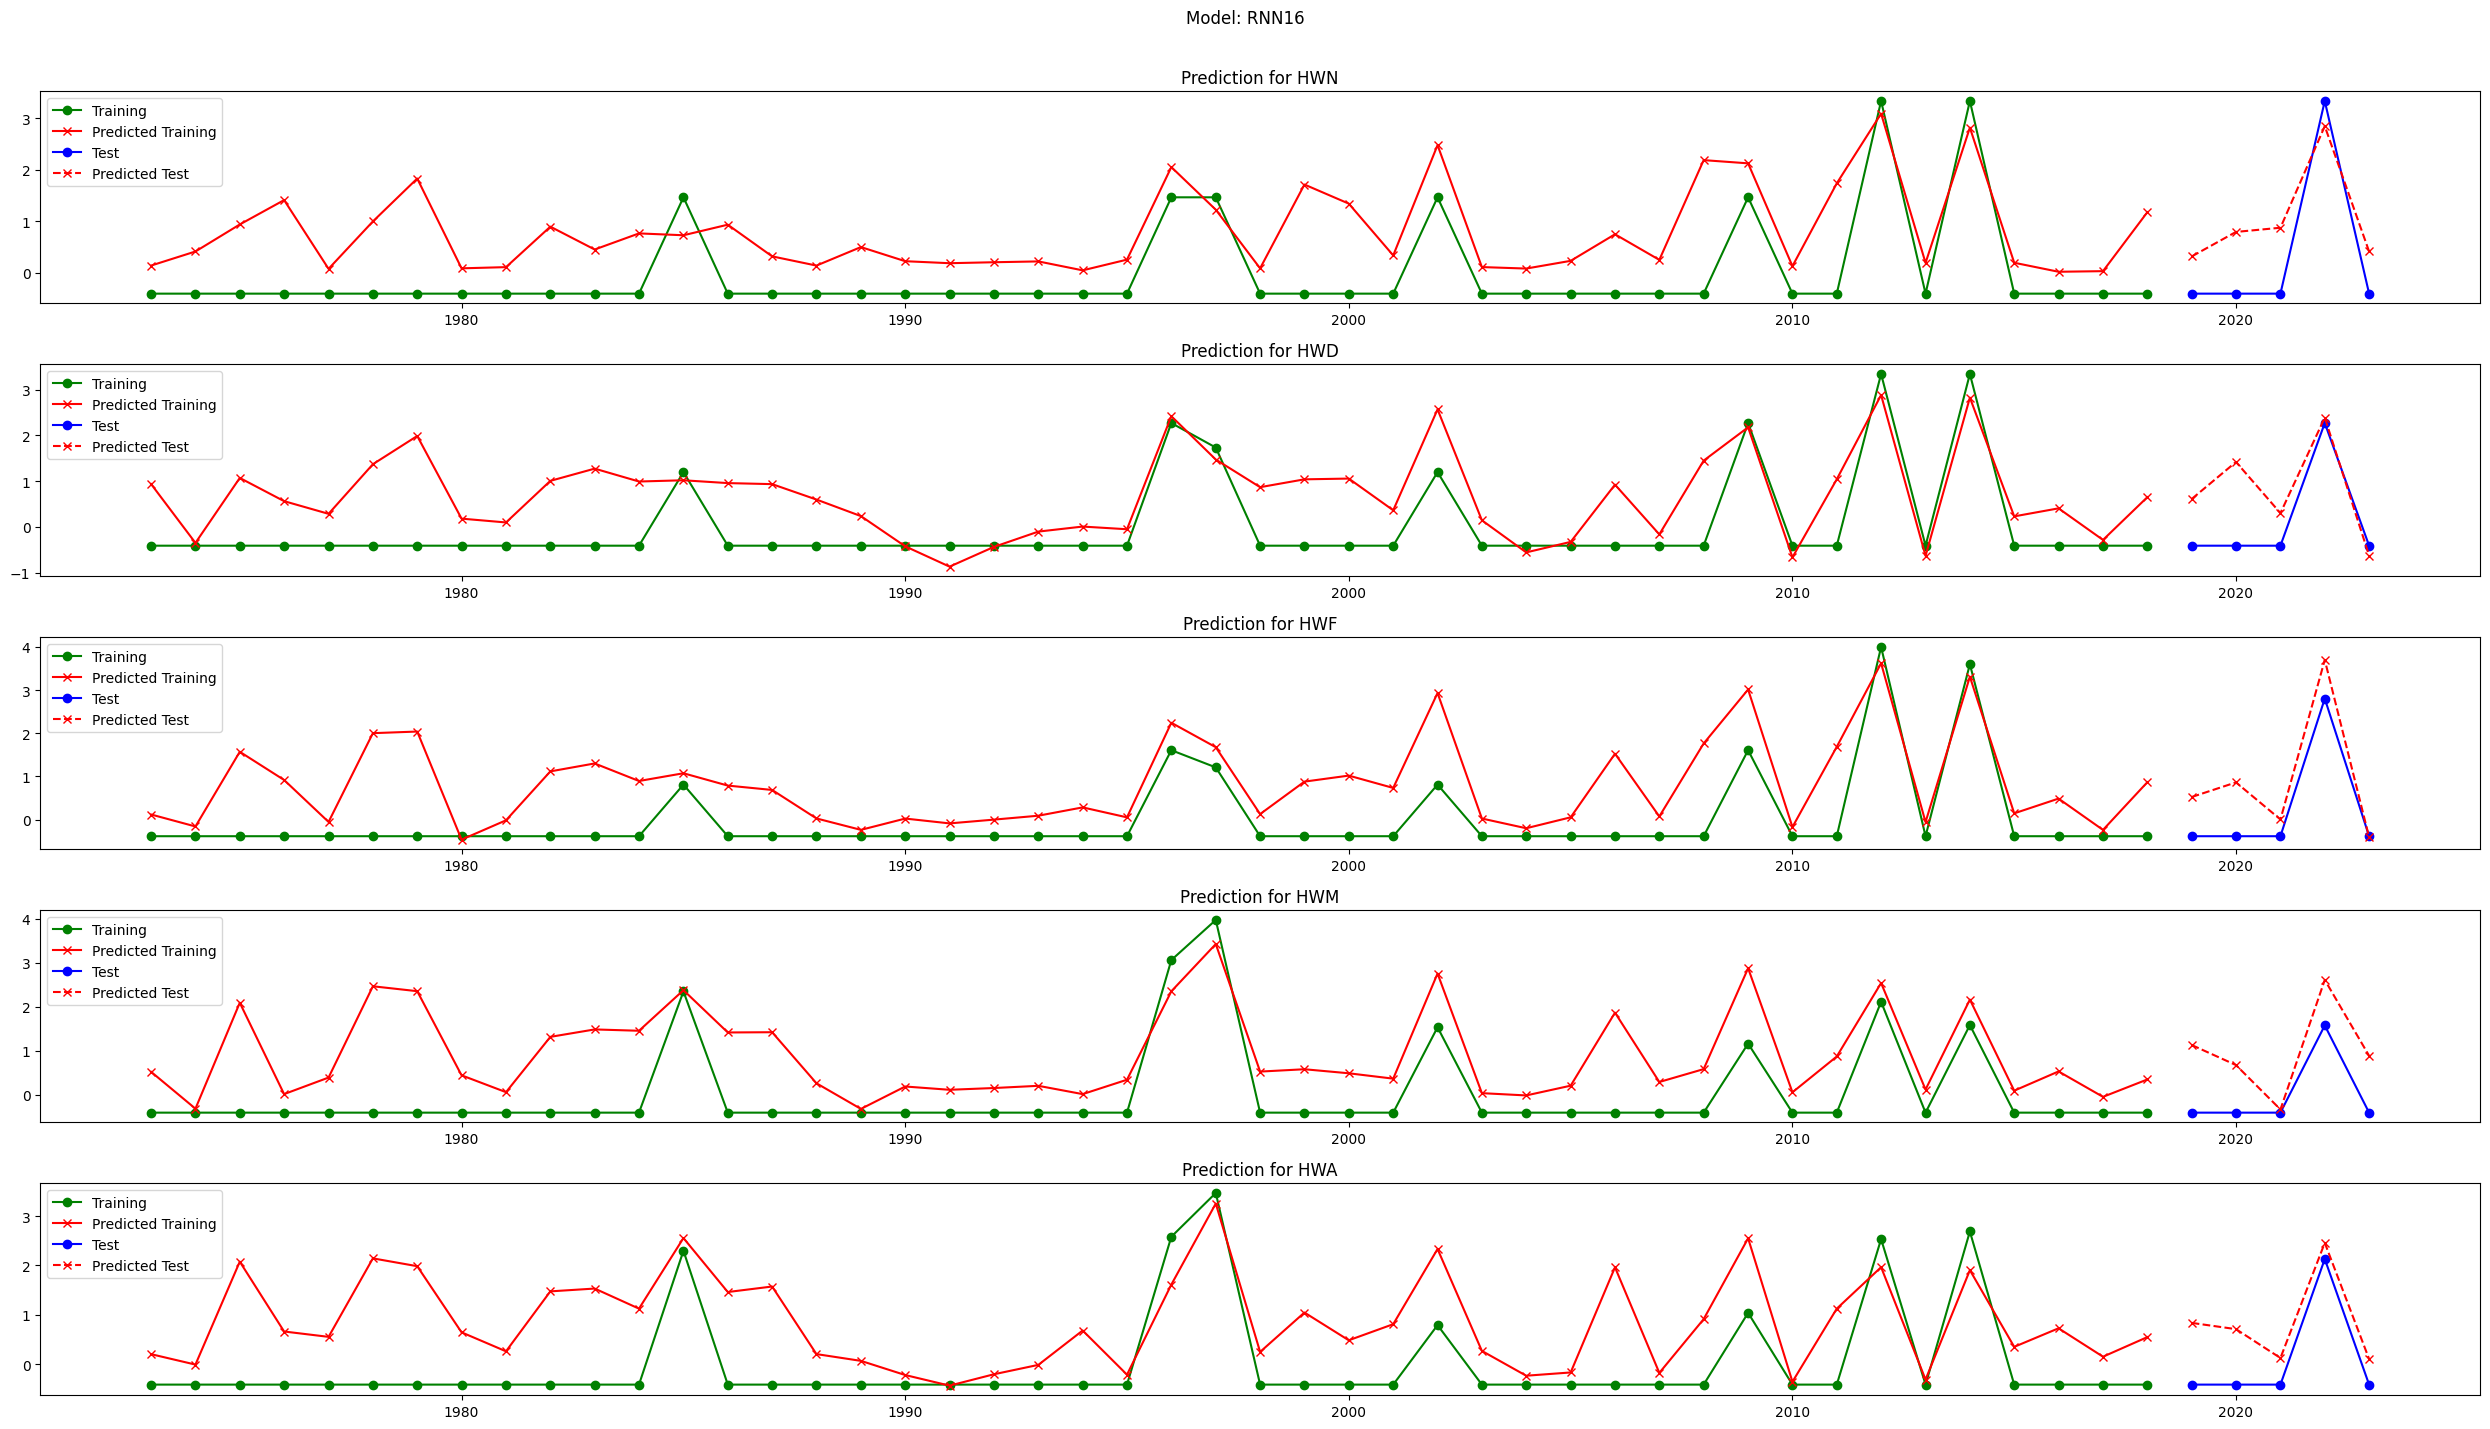

In [43]:
loss_fn = SERA(bounds=bounds, y_bounds=y_bounds,T=100)

id = "231a6330"
season = 12
data = pd.read_parquet(f"data/locally_features/{region}/predictor_{id}_{season}.parquet")
# data = data.drop(columns=["HWF", "HWM", "HWD", "HWA"])
model = Sequential([
    SimpleRNN(16, activation="tanh", input_shape=(1, len(data.columns) - 5)),
    Dropout(0.1),  # Regularization
    Dense(8, activation="relu"),
    Dense(5)  # Predict 1 indices
    ])

pred = PredictionModel(data, season, indices, model, name_regressor="RNN16", loss_fn=loss_fn)
pred.compile_keras_model(metrics="mae")
y_train, y_pred_train = pred.train(5)
y_test, y_pred = pred.predict(5)
dates = pd.date_range(pd.to_datetime(f"1972-{season}"),periods=len(y_train) + len(y_test),freq=pd.offsets.YearBegin(1))
pred.plot_predictions(dates, 5, y_train, y_pred_train, y_test, y_pred)

Epoch 1/200
6/6 [==============================] - 16s 669ms/step - loss: 6.3196 - mae: 0.9118 - val_loss: 1.5752 - val_mae: 0.7654
Epoch 2/200
6/6 [==============================] - 0s 7ms/step - loss: 5.7902 - mae: 0.9257 - val_loss: 1.4903 - val_mae: 0.7575
Epoch 3/200
6/6 [==============================] - 0s 7ms/step - loss: 5.1248 - mae: 0.8895 - val_loss: 1.4105 - val_mae: 0.7525
Epoch 4/200
6/6 [==============================] - 0s 7ms/step - loss: 5.3565 - mae: 0.9129 - val_loss: 1.3297 - val_mae: 0.7468
Epoch 5/200
6/6 [==============================] - 0s 8ms/step - loss: 5.2378 - mae: 0.8828 - val_loss: 1.2549 - val_mae: 0.7406
Epoch 6/200
6/6 [==============================] - 0s 7ms/step - loss: 4.5829 - mae: 0.8695 - val_loss: 1.1908 - val_mae: 0.7351
Epoch 7/200
6/6 [==============================] - 0s 8ms/step - loss: 4.7771 - mae: 0.8941 - val_loss: 1.1244 - val_mae: 0.7276
Epoch 8/200
6/6 [==============================] - 0s 8ms/step - loss: 4.2550 - mae: 0.8650 - 

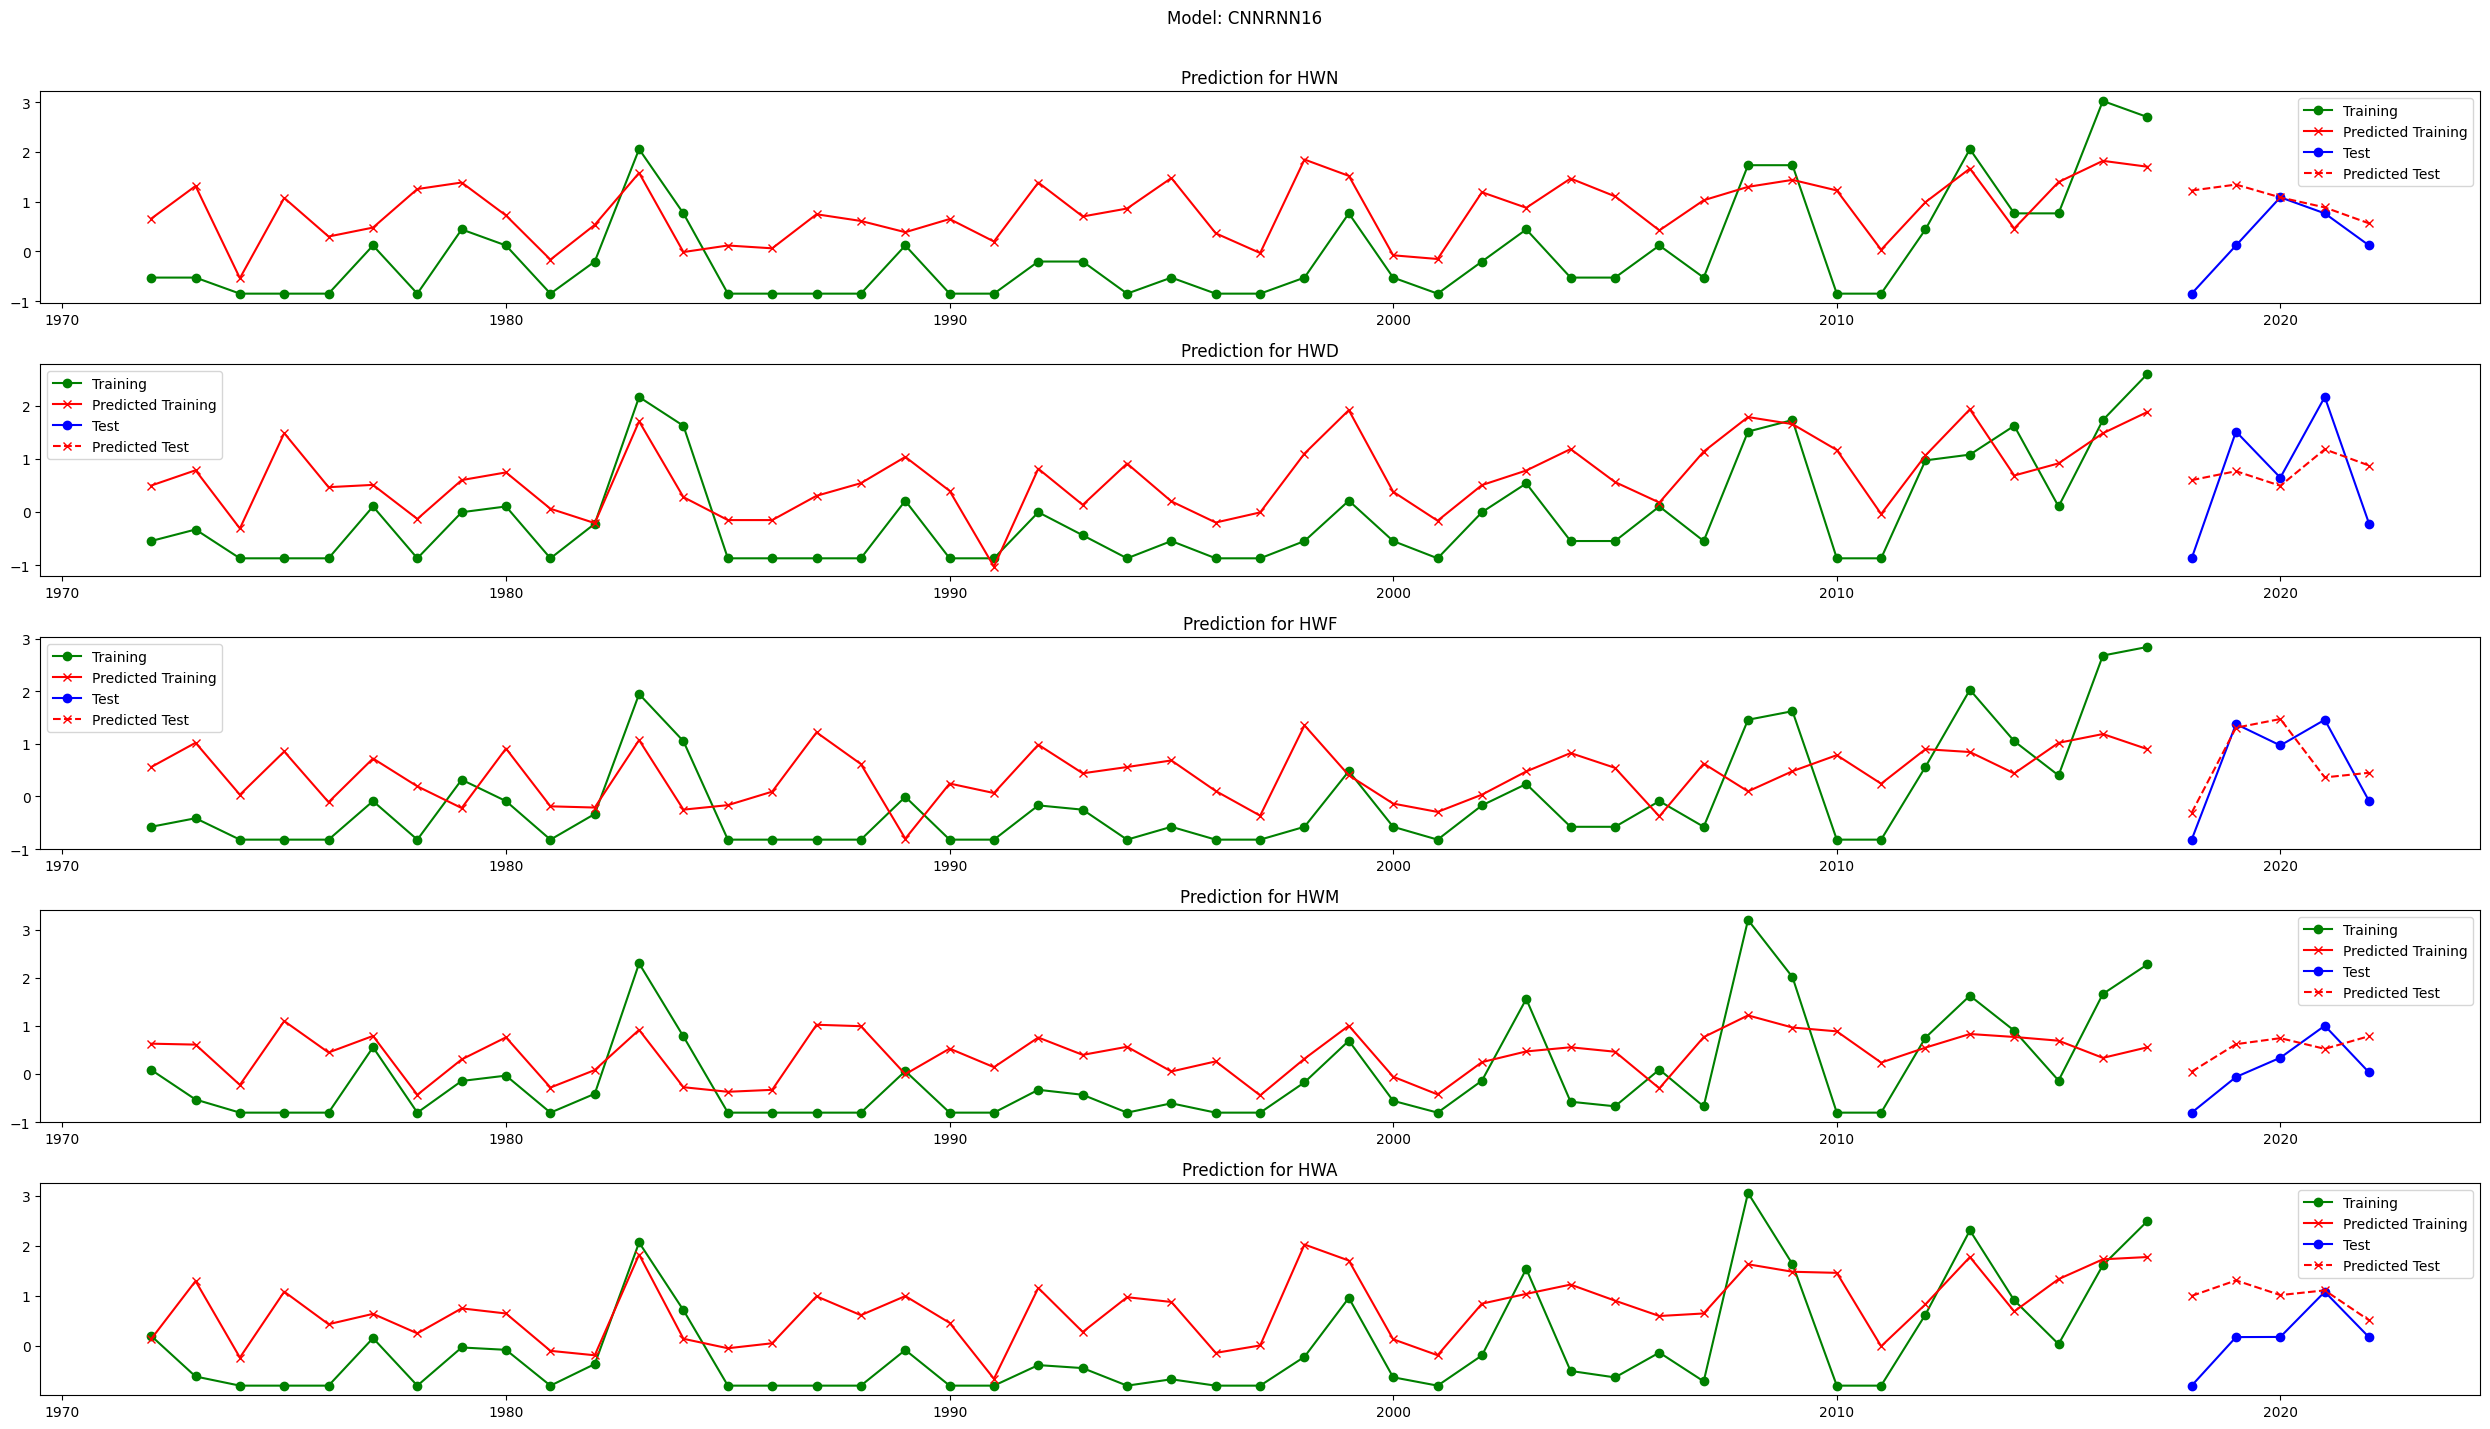

In [44]:
loss_fn = SERA(bounds=bounds, y_bounds=y_bounds,T=100)

id = "ecf2577f"
season = 1
data = pd.read_parquet(f"data/climate_features/{region}/predictor_{id}_{season}.parquet")
# data = data.drop(columns=["HWF", "HWM", "HWD", "HWA"])
model = Sequential([
        Conv1D(16, kernel_size=1, activation="relu", input_shape=(1, len(data.columns) - len(indices))),
        Reshape((1, 16)),  # Back to time dimension
        SimpleRNN(8, activation="tanh"),
        Dropout(0.1),
        Dense(len(indices))
    ])

pred = PredictionModel(data, season, indices, model, name_regressor="CNNRNN16",loss_fn=loss_fn)
pred.compile_keras_model( metrics="mae")
y_train, y_pred_train = pred.train(5)
y_test, y_pred = pred.predict(5)
dates = pd.date_range(pd.to_datetime(f"1972-{season}"),periods=len(y_train) + len(y_test),freq=pd.offsets.YearBegin(1))
pred.plot_predictions(dates, 5, y_train, y_pred_train, y_test, y_pred)

## Season specific relevance fn opt

### January

In [46]:
hws_jan = hws[hws.index.month==1]
hws_index = hws_jan[["HWF"]].to_numpy()
hws_index = hws_index.reshape(hws_index.shape[0])
relevance = kde_based_relevance_function(hws_index)

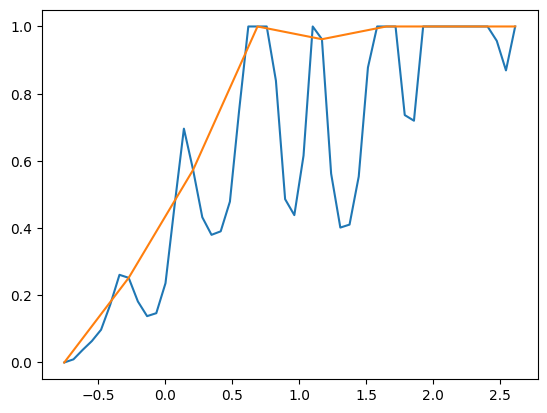

In [47]:
x = np.linspace(np.min(hws_index), np.max(hws_index))
bounds = (x[0], x[7], x[14], x[21], x[28], x[35], x[42])
y_bounds = [relevance(xs) for xs in bounds]
# f2 = piecewise_linear_phi(hws_index, bounds)
plt.plot(x, relevance(x))
plt.plot(x, piecewise_linear_phi(x, bounds, y_bounds))

Epoch 1/200
6/6 [==============================] - 16s 646ms/step - loss: 42.2697 - mae: 0.9302 - val_loss: 28.9589 - val_mae: 0.9842
Epoch 2/200
6/6 [==============================] - 0s 8ms/step - loss: 37.0251 - mae: 0.9195 - val_loss: 28.1447 - val_mae: 0.9771
Epoch 3/200
6/6 [==============================] - 0s 9ms/step - loss: 35.3163 - mae: 0.9201 - val_loss: 27.3303 - val_mae: 0.9725
Epoch 4/200
6/6 [==============================] - 0s 9ms/step - loss: 34.2522 - mae: 0.8948 - val_loss: 26.4767 - val_mae: 0.9668
Epoch 5/200
6/6 [==============================] - 0s 9ms/step - loss: 32.9488 - mae: 0.8946 - val_loss: 25.5209 - val_mae: 0.9572
Epoch 6/200
6/6 [==============================] - 0s 9ms/step - loss: 29.3635 - mae: 0.8883 - val_loss: 24.8826 - val_mae: 0.9529
Epoch 7/200
6/6 [==============================] - 0s 9ms/step - loss: 30.3250 - mae: 0.8718 - val_loss: 24.1892 - val_mae: 0.9471
Epoch 8/200
6/6 [==============================] - 0s 9ms/step - loss: 28.5086 -

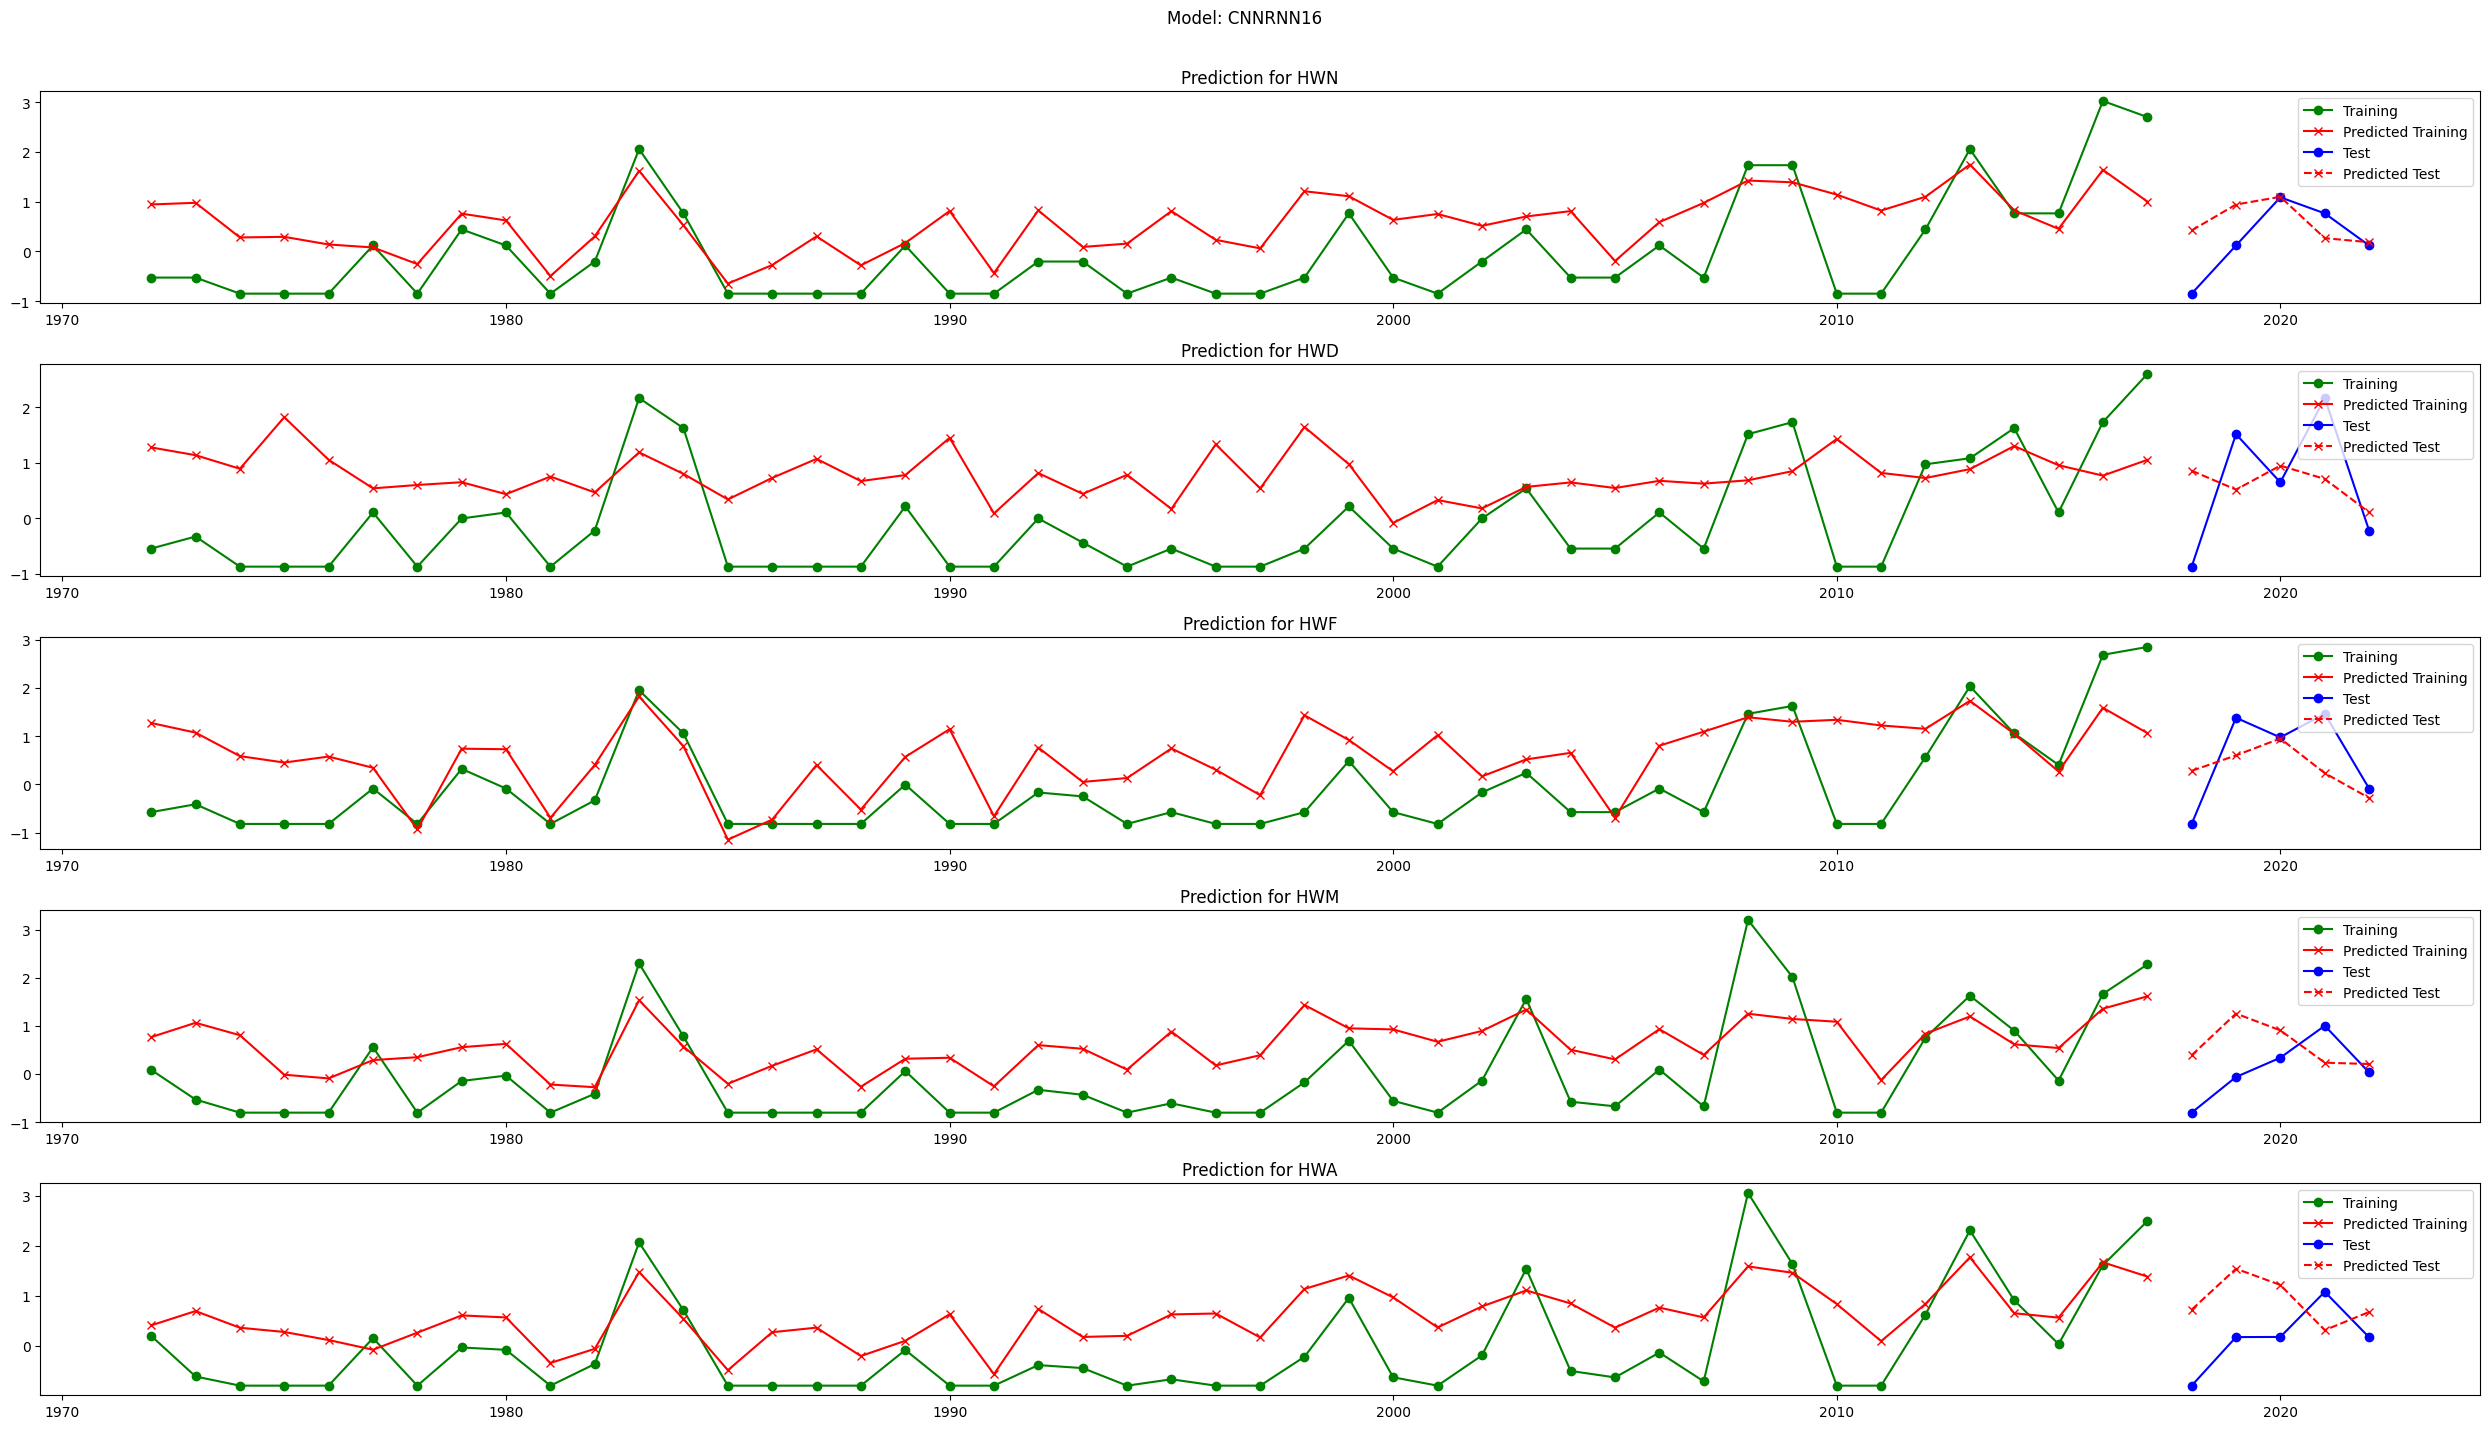

In [48]:
loss_fn = SERA(bounds=bounds, y_bounds=y_bounds,T=100)

id = "d7101242"
season = 1
data = pd.read_parquet(f"data/climate_features/{region}/predictor_{id}_{season}.parquet")
# data = data.drop(columns=["HWF", "HWM", "HWD", "HWA"])
model = Sequential([
        Conv1D(16, kernel_size=1, activation="relu", input_shape=(1, len(data.columns) - len(indices))),
        Reshape((1, 16)),  # Back to time dimension
        SimpleRNN(8, activation="tanh"),
        Dropout(0.1),
        Dense(len(indices))
    ])

pred = PredictionModel(data, season, indices, model, name_regressor="CNNRNN16",loss_fn=loss_fn)
pred.compile_keras_model( metrics="mae")
y_train, y_pred_train = pred.train(5)
y_test, y_pred = pred.predict(5)
dates = pd.date_range(pd.to_datetime(f"1972-{season}"),periods=len(y_train) + len(y_test),freq=pd.offsets.YearBegin(1))
pred.plot_predictions(dates, 5, y_train, y_pred_train, y_test, y_pred)

### December

In [49]:
hws_dec = hws[hws.index.month==12]
hws_index = hws_dec[["HWF"]].to_numpy()
hws_index = hws_index.reshape(hws_index.shape[0])
relevance = kde_based_relevance_function(hws_index)

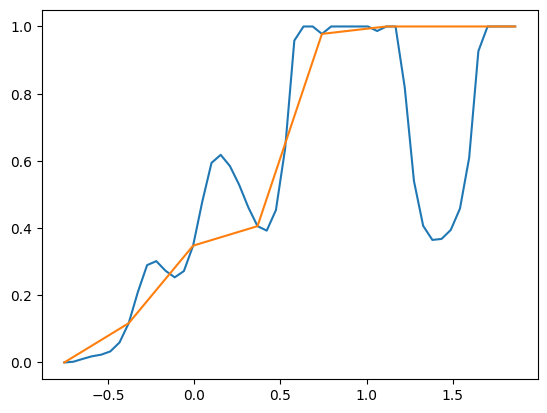

In [50]:
x = np.linspace(np.min(hws_index), np.max(hws_index))
bounds = (x[0], x[7], x[14], x[21], x[28], x[35], x[42])
y_bounds = [relevance(xs) for xs in bounds]
# f2 = piecewise_linear_phi(hws_index, bounds)
plt.plot(x, relevance(x))
plt.plot(x, piecewise_linear_phi(x, bounds, y_bounds))

Epoch 1/200
6/6 [==============================] - 16s 639ms/step - loss: 29.7163 - mae: 0.7382 - val_loss: 30.0354 - val_mae: 0.7644
Epoch 2/200
6/6 [==============================] - 0s 7ms/step - loss: 30.3803 - mae: 0.7310 - val_loss: 28.9158 - val_mae: 0.7621
Epoch 3/200
6/6 [==============================] - 0s 7ms/step - loss: 28.8185 - mae: 0.7123 - val_loss: 27.2793 - val_mae: 0.7566
Epoch 4/200
6/6 [==============================] - 0s 8ms/step - loss: 25.9245 - mae: 0.6954 - val_loss: 25.6592 - val_mae: 0.7516
Epoch 5/200
6/6 [==============================] - 0s 8ms/step - loss: 26.2422 - mae: 0.7231 - val_loss: 24.1089 - val_mae: 0.7468
Epoch 6/200
6/6 [==============================] - 0s 8ms/step - loss: 22.1508 - mae: 0.7004 - val_loss: 22.6070 - val_mae: 0.7422
Epoch 7/200
6/6 [==============================] - 0s 9ms/step - loss: 24.7939 - mae: 0.7272 - val_loss: 21.2512 - val_mae: 0.7387
Epoch 8/200
6/6 [==============================] - 0s 8ms/step - loss: 21.4314 -

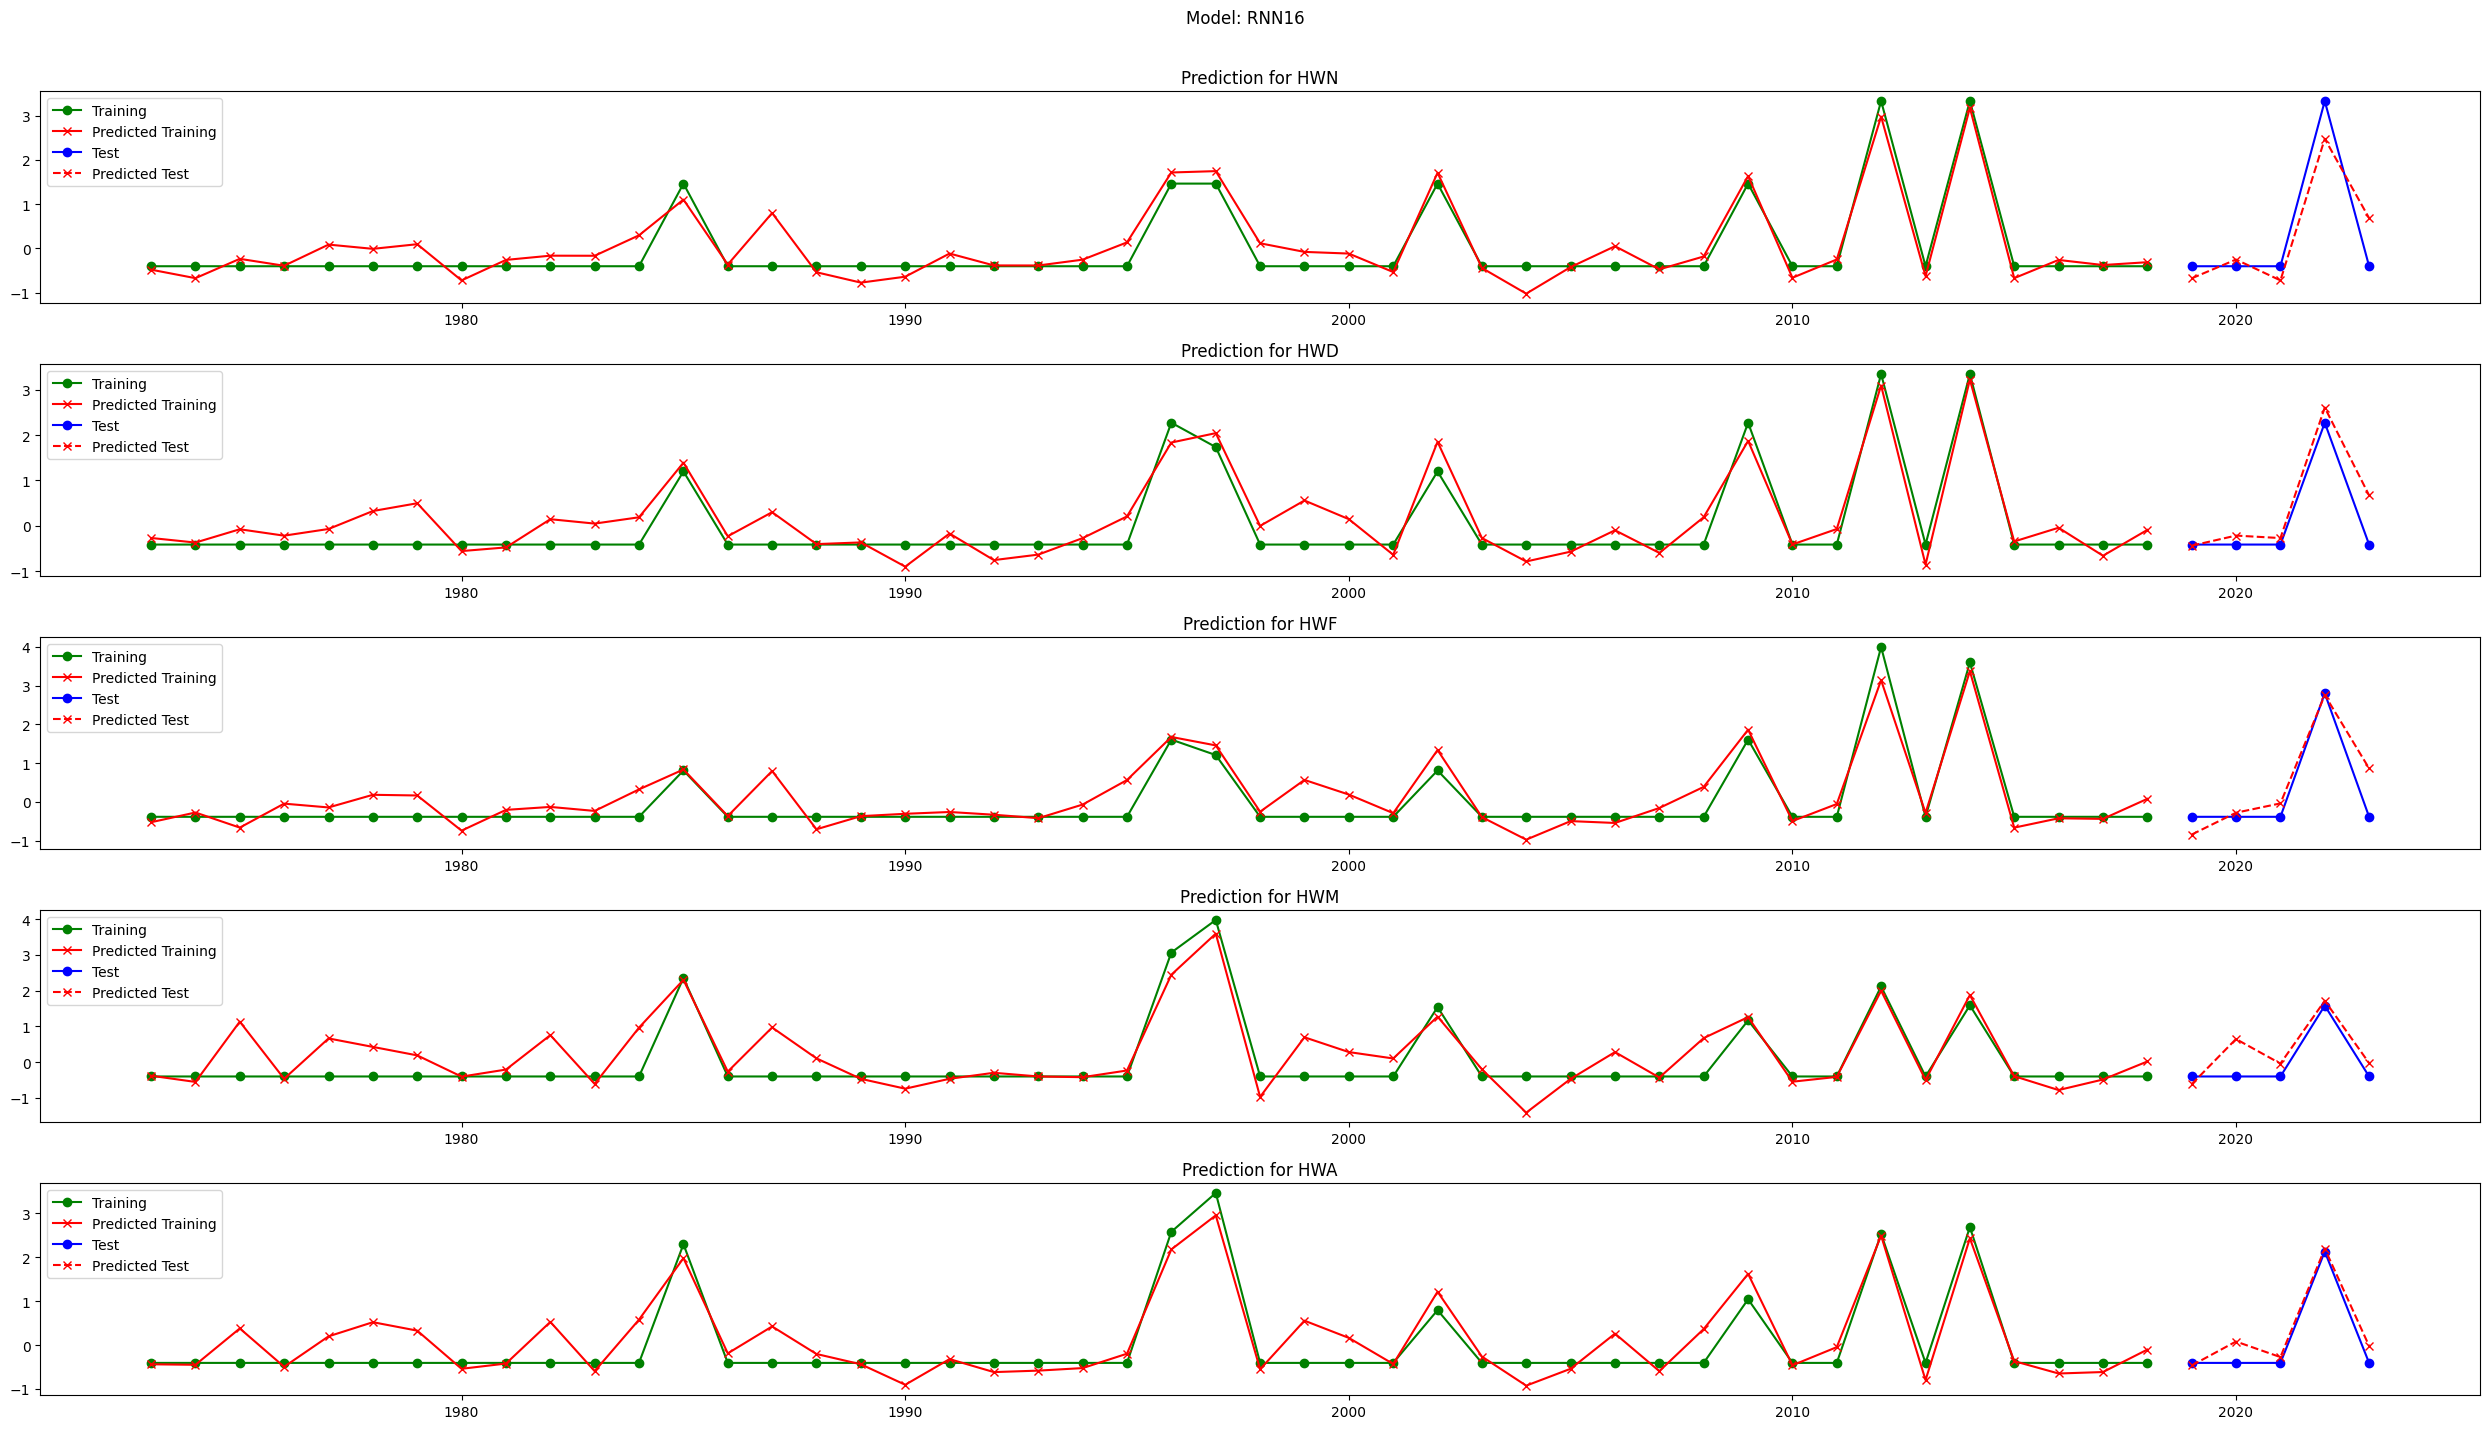

In [54]:
loss_fn = SERA(bounds=bounds, y_bounds=y_bounds,T=100)

id = "231a6330"
season = 12
data = pd.read_parquet(f"data/locally_features/{region}/predictor_{id}_{season}.parquet")
# data = data.drop(columns=["HWF", "HWM", "HWD", "HWA"])
model = Sequential([
    SimpleRNN(16, activation="tanh", input_shape=(1, len(data.columns) - 5)),
    Dropout(0.1),  # Regularization
    Dense(8, activation="relu"),
    Dense(5)  # Predict 1 indices
    ])

pred = PredictionModel(data, season, indices, model, name_regressor="RNN16", loss_fn=loss_fn)
pred.compile_keras_model(metrics="mae")
y_train, y_pred_train = pred.train(5)
y_test, y_pred = pred.predict(5)
dates = pd.date_range(pd.to_datetime(f"1972-{season}"),periods=len(y_train) + len(y_test),freq=pd.offsets.YearBegin(1))
pred.plot_predictions(dates, 5, y_train, y_pred_train, y_test, y_pred)